In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import xgboost as xgb
import json

save_result = 'DECILE_PUNT_GLOBAL' #-> run this notebook to save the predictions for this label!

# XGBoost

In [2]:
# Data directory
data_dir = "../../../data/unziped_data/"

# Open data with pickle
data_for_training = "../../../data/Data_For_Training/"
data_original = pd.read_csv(data_for_training + "icfes_20142.csv")

# lista de las columnas con las caracteristicas a predecir
notasz = [c for c in data_original.columns.values if c.startswith("NOTA_Z")]
deciles = [c for c in data_original.columns.values if c.startswith("DECILE")]
labels_names = notasz + deciles
puntajes = [decil.replace('DECILE_','') for decil in deciles]


# lista de las columnas que se van a omitir de las caracteristicas
vars_2_omit = (
    [
        "PUNT_LECTURA_CRITICA",
        "DECIL_LECTURA_CRITICA",
        "PUNT_MATEMATICAS",
        "DECIL_MATEMATICAS",
        "PUNT_C_NATURALES",
        "DECIL_C_NATURALES",
        "PUNT_SOCIALES_CIUDADANAS",
        "DECIL_SOCIALES_CIUDADANAS",
        "PUNT_RAZONA_CUANTITATIVO",
        "DECIL_RAZONA_CUANTITATIVO",
        "PUNT_COMP_CIUDADANA",
        "DECIL_COMP_CIUDADANA",
        "PUNT_INGLES",
        "DECIL_INGLES",
        "PUNT_GLOBAL",
        "ESTU_PUESTO",
    ]
    + deciles
    + notasz
)




labels = data_original[labels_names]
features = data_original.drop(vars_2_omit, axis=1)
#features_train, features_test, labels_train, labels_test = train_test_split(
#    features, labels, test_size=0.2, random_state=42
#)
# Mascara para los modelos que predicen la Nota Z
mask_nota_z = [False if 'COLE' in col or 'DEPTO' in col or 'MCPIO' in col or "ESTABLECIMIENTO" in col else True for col in features.columns]

In [3]:
#Cargar los escaladores
scaler_features = pickle.load(open("../models/scaler_features_20142.pkl", "rb"))
scaler_labels = pickle.load(open("../models/scaler_labels_20142.pkl", "rb"))
# Escalar las caracteristicas
X = scaler_features.transform(features)
Y = scaler_labels.transform(labels)
# Hacer las predicciones de los resultados
Y_pred = np.zeros(labels.shape)
Y_pred.fill(np.nan)
for ii in range(len(labels_names)):
    print(labels_names[ii])
    bst = xgb.Booster({'nthread': 4})  # init model
    bst.load_model("../models/icfes_20142_{0}.model".format(labels_names[ii]))
    idx = np.where(~np.isnan(Y[:, ii]))
    if "NOTA_Z" in labels_names[ii]:
        dtotal = xgb.DMatrix(X[idx[0]][:, mask_nota_z])
    else:
        dtotal = xgb.DMatrix(X[idx[0]])
    ypred = bst.predict(dtotal)
    Y_pred[idx[0],ii] = ypred
#Crear dataframe con labels no escaladas y prediciones no escaladas
Y_pred_real = scaler_labels.inverse_transform(Y_pred)
pred_lables = [label+'_pred' for label in labels_names]
columns = features.columns.to_list() + puntajes + labels_names + pred_lables
total_data = np.concatenate((features.values,data_original[puntajes].values, labels.values,Y_pred_real),axis=1)
data = pd.DataFrame(data=total_data,columns=columns)

/home/trucupey/.virtualenvs/ICFES-SocioEconomico-Qp25LKX0/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS
NOTA_Z_COLE_CODIGO_ICFES_PUNT_LECTURA_CRITICA
NOTA_Z_COLE_CODIGO_ICFES_PUNT_C_NATURALES
NOTA_Z_COLE_CODIGO_ICFES_PUNT_SOCIALES_CIUDADANAS
NOTA_Z_COLE_CODIGO_ICFES_PUNT_RAZONA_CUANTITATIVO
NOTA_Z_COLE_CODIGO_ICFES_PUNT_COMP_CIUDADANA
NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES
NOTA_Z_COLE_CODIGO_ICFES_PUNT_GLOBAL
NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO
DECILE_PUNT_MATEMATICAS
DECILE_PUNT_LECTURA_CRITICA
DECILE_PUNT_C_NATURALES
DECILE_PUNT_SOCIALES_CIUDADANAS
DECILE_PUNT_RAZONA_CUANTITATIVO
DECILE_PUNT_COMP_CIUDADANA
DECILE_PUNT_INGLES
DECILE_PUNT_GLOBAL
DECILE_ESTU_PUESTO


_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS
[[131730 113507]
 [ 79072 220092]]
presicion 53.7%
recall 62.5%
accuracy 64.6%


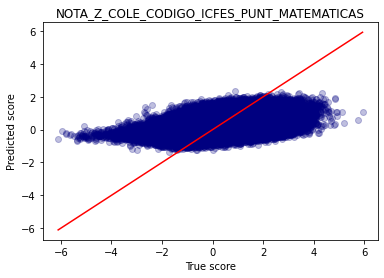

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_LECTURA_CRITICA
[[139772 108996]
 [ 80062 215571]]
presicion 56.2%
recall 63.6%
accuracy 65.3%


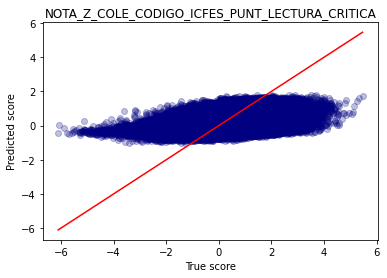

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_C_NATURALES
[[136498 112588]
 [ 71225 224090]]
presicion 54.8%
recall 65.7%
accuracy 66.2%


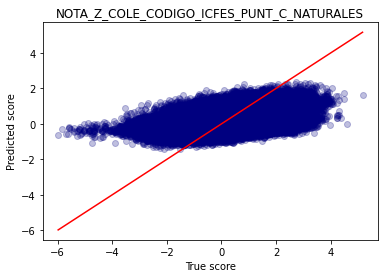

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_SOCIALES_CIUDADANAS
[[137524 112893]
 [ 76702 217282]]
presicion 54.9%
recall 64.2%
accuracy 65.2%


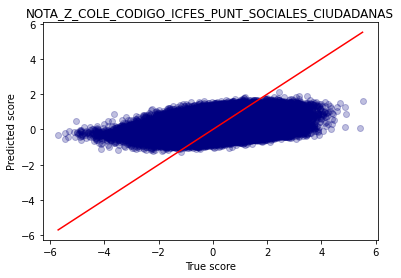

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_RAZONA_CUANTITATIVO
[[129958 117263]
 [ 79556 217624]]
presicion 52.6%
recall 62.0%
accuracy 63.8%


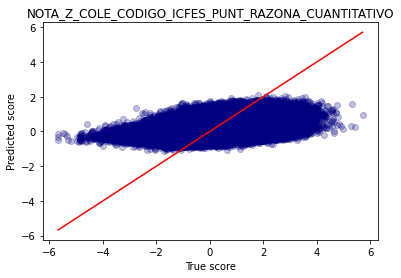

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_COMP_CIUDADANA
[[139674 108621]
 [ 83160 212946]]
presicion 56.3%
recall 62.7%
accuracy 64.8%


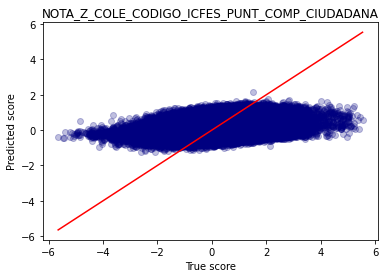

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES
[[179864  53753]
 [ 39201 271583]]
presicion 77.0%
recall 82.1%
accuracy 82.9%


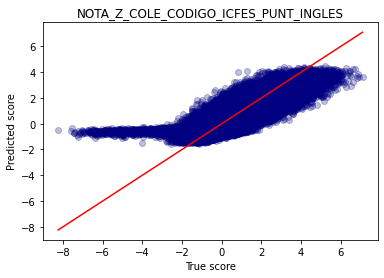

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_PUNT_GLOBAL
[[140832  98680]
 [ 70357 234532]]
presicion 58.8%
recall 66.7%
accuracy 68.9%


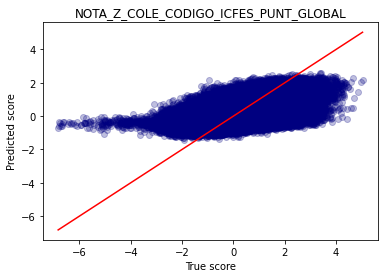

_________________________________________
NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO
[[183983  64907]
 [ 97188 198323]]
presicion 73.9%
recall 65.4%
accuracy 70.2%


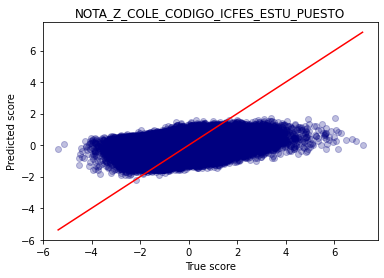

51.00032843395668   571
_________________________________________
PUNT_MATEMATICAS
[[129430 103574]
 [ 39655 271742]]
presicion 55.5%
recall 76.5%
accuracy 73.7%


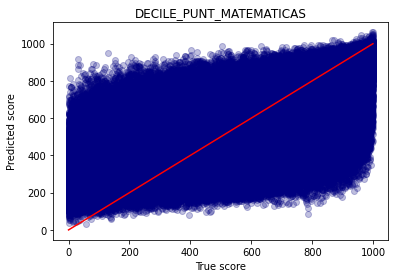

51.00006831849404   517
_________________________________________
PUNT_LECTURA_CRITICA
[[176496  85905]
 [ 55760 226240]]
presicion 67.3%
recall 76.0%
accuracy 74.0%


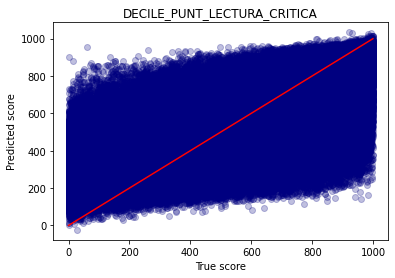

51.00004042204516   548
_________________________________________
PUNT_C_NATURALES
[[154115  91410]
 [ 43120 255756]]
presicion 62.8%
recall 78.1%
accuracy 75.3%


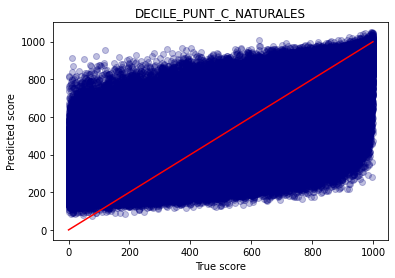

50.00000954930094   481
_________________________________________
PUNT_SOCIALES_CIUDADANAS
[[198438  83562]
 [ 65080 197321]]
presicion 70.4%
recall 75.3%
accuracy 72.7%


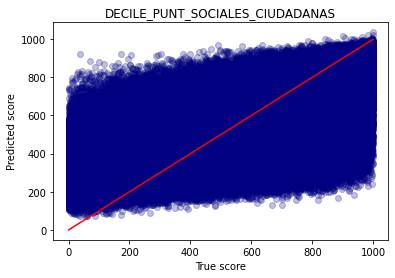

51.00017645276118   537
_________________________________________
PUNT_RAZONA_CUANTITATIVO
[[142648 108865]
 [ 52893 239995]]
presicion 56.7%
recall 73.0%
accuracy 70.3%


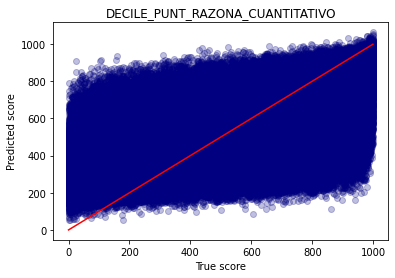

51.000489993364624   536
_________________________________________
PUNT_COMP_CIUDADANA
[[154662  97396]
 [ 51318 241025]]
presicion 61.4%
recall 75.1%
accuracy 72.7%


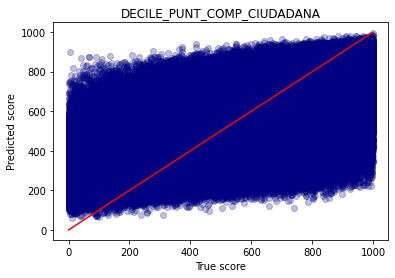

51.000250883689816   633
_________________________________________
PUNT_INGLES
[[198934    317]
 [ 61652 283498]]
presicion 99.8%
recall 76.3%
accuracy 88.6%


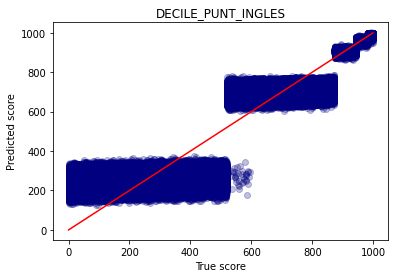

251.00151482476988   544
_________________________________________
PUNT_GLOBAL
[[168282  79420]
 [ 41643 255056]]
presicion 67.9%
recall 80.2%
accuracy 77.8%


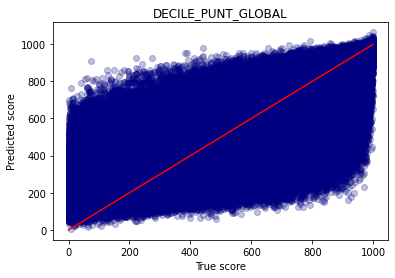

505.0135679801458   501
_________________________________________
ESTU_PUESTO
[[220993  50119]
 [ 72464 200825]]
presicion 81.5%
recall 75.3%
accuracy 77.5%


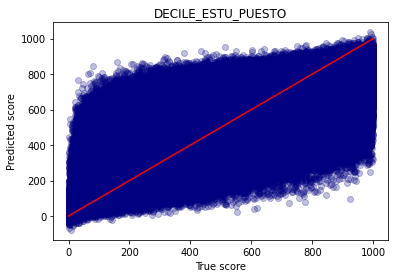

In [4]:
save_result = 'DECILE_PUNT_GLOBAL' #-> run this notebook to save the predictions for this label!
for label in labels_names:
    if 'DECIL' in label:
        puntaje = label.replace('DECILE_','')
        np.random.seed(0)
        maxval = data_original[puntaje].max()
        minval = data_original[puntaje].min()
        size = data_original[puntaje].shape[0]
        rangeval = (maxval - minval) / 10000
        data_original[puntaje+'_plus_noise'] = data_original[puntaje] + np.random.uniform(0, rangeval, size)
        mililes = data_original[puntaje+'_plus_noise'].quantile([ii/1000 for ii in range(1,1000)]).values
        mean_puntaje = data_original[puntaje].mean()
        for ii in range(len(mililes)):
            if mililes[ii] >= mean_puntaje:
                reference_value = ii + 1
                print(mililes[ii],' ',ii)
                break    
    else:
        puntaje = label
        reference_value = 0
    data['{}_above_average'.format(label)] = data[label].apply(lambda x: 
            'Above' if x >= reference_value else 'Below')
    data['{}_pred_above_average'.format(label)] = data['{}_pred'.format(label)].apply(lambda x: 
            'Above' if x >= reference_value else 'Below')
    y_real = data['{}_above_average'.format(label)].tolist()
    y_pred = data['{}_pred_above_average'.format(label)].tolist()
    cm = confusion_matrix(y_real,y_pred, labels=['Above','Below'] )
    print('_________________________________________')
    print(puntaje)
    print(cm)
    print('presicion {:.1f}%'.format(cm[0,0]*100/(cm[0,0]+cm[0,1])))
    print('recall {:.1f}%'.format(cm[0,0]*100/(cm[0,0]+cm[1,0]))) 
    print('accuracy {:.1f}%'.format((cm[0,0]+cm[1,1])*100/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])))
    y_real = data[label].values
    y_pred = data['{}_pred'.format(label)].values
    fig, ax = plt.subplots()
    ax.scatter(y_real, y_pred, alpha=0.25, color='navy')
    ax.set_title(label)
    ax.set_xlabel('True score')
    ax.set_ylabel('Predicted score')
    #axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Above', 'Below'])
    #disp = disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=axins)
    minx = np.min(y_real[~np.isnan(y_real)])
    maxx = np.max(y_real[~np.isnan(y_real)])
    ax.plot([minx, maxx], [minx, maxx], ls='-', color='red')
    if label == save_result:
        plt.savefig('../XGBoost_error_dispersion_plot.png', dpi=300, bbox_inches='tight')
    plt.show()   